In [32]:
import os
import glob
import pandas as pd

In [14]:
companies = open("companies.txt").read().splitlines()

In [52]:
string = "cybersecurity"

df = pd.DataFrame(columns=['Company', 'Date', 'Word_count', 'Filing', 'Path'])

for company in companies:
    path_10K = glob.glob(f'sec-edgar-filings/{company}/10-K/*/*.txt')
    path_8K = glob.glob(f'sec-edgar-filings/{company}/8-K/*/*.txt')

    path_globs = [path_10K, path_8K]

    for path_glob in path_globs:

        for path in path_glob:
            file = open(path, "r")
            string_count = 0

            if '10-K' in path:
                filing = '10K'
            elif '8-K' in path:
                filing = '8K'
            else:
                filing = 'Error'

            # get date of file
            for line in file:
                date = line[-9:-1]
                break
            
            # get work count of file
            for line in file:
                if string in line.lower():
                    string_count += 1
            
            df.loc[len(df.index)] = [company, date, string_count, filing, path]
            file.close()

# convert date to datetime and sort in order
df['Date'] = pd.to_datetime(df['Date'],format='%Y%m%d')
df = df.sort_values(by='Date')

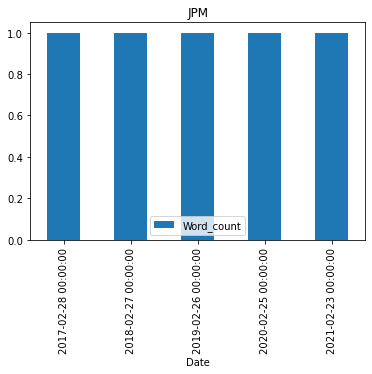

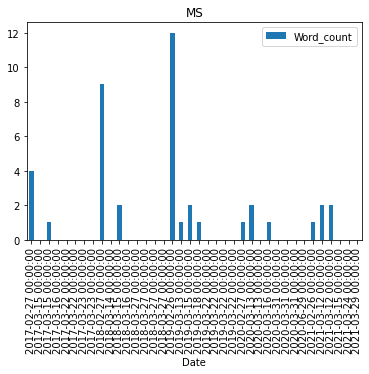

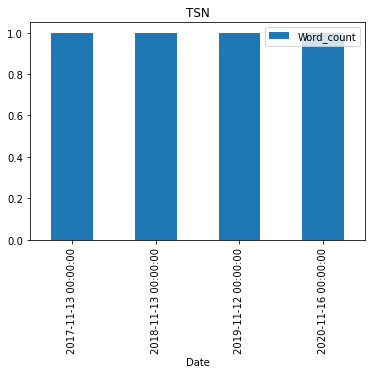

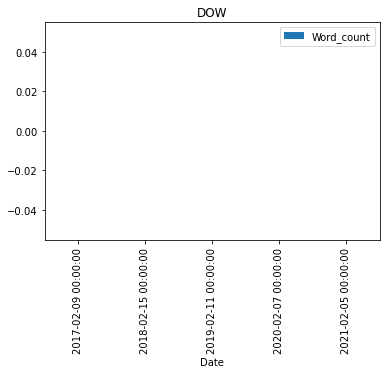

In [53]:
# 10K counts
for company in companies:
    df.loc[(df['Company'] == company) & (df['Filing'] == '10K')].plot(x='Date', y='Word_count', kind='bar', title = company)

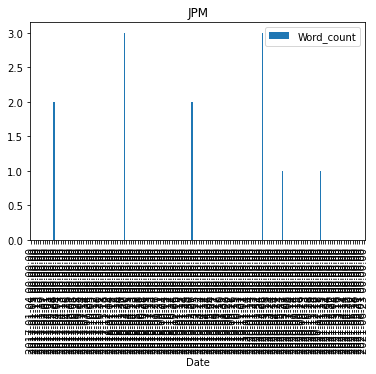

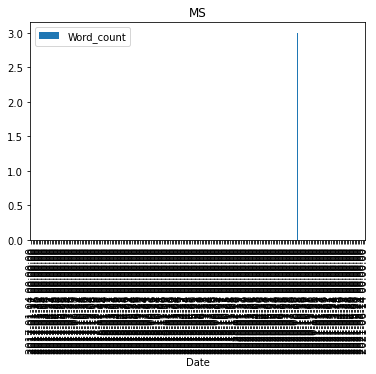

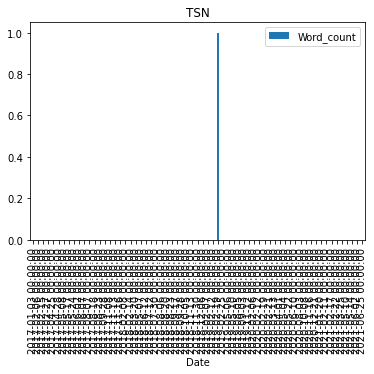

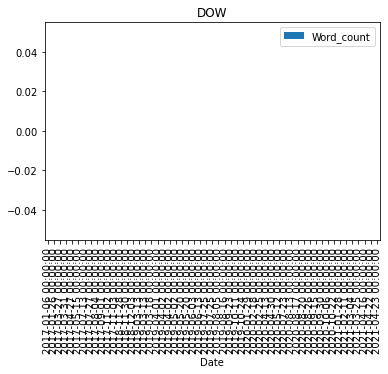

In [54]:
# 8K counts
for company in companies:
    df.loc[(df['Company'] == company) & (df['Filing'] == '8K')].plot(x='Date', y='Word_count', kind='bar', title = company)